<a href="https://colab.research.google.com/github/Farmhouse121/Financial-Data-Science-in-Python/blob/main/Alphas/Market_Return_by_Dates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from my_library import *

13:49:31 Starting...
13:49:32 Installing yfinance into Google notebook...
13:49:44 Installing arch into Google notebook...
13:49:56 Initialized.


## Get the Data

In [39]:
data,ticker_name=download(ticker:='SPY',start='1990-02-01',end='2019-12-31',auto_adjust=True).xs(ticker,axis=1,level=1),'S&P 500 Index ETF'
data['Return']=data['Close'].pct_change()*hundred
data.columns.name=ticker_name
data.dropna(inplace=True)
data.index=list(map(lambda x:pd.Period(x,'D'),data.index))
data['Weekday']=list(map(lambda x:x.strftime("%A"),data.index))
data['Monthday']=data.index.day
data['DaysInMonth']=list(map(lambda x:pd.Period(x,'M').daysinmonth,data.index))
data['Month']=list(map(lambda x:x.strftime("%B"),data.index))
data['FirstPayment']=(data['Monthday']==1)|(data['Monthday'].shift(-1).isin([2,3,4]))&(data['Month']!=data['Month'].shift(-1))
data['SecondPayment']=(data['Monthday']>=15)&(data['Monthday'].shift()<15)
data['Payday']=(data['FirstPayment']|data['SecondPayment']).apply(lambda x:"Payday" if x else "Regular")
data['Julian']=list(map(lambda x:float((x-data.index[0]).n),data.index))
data['DaysSincePayment']=data['Julian']-(data['Julian']*data['Payday'].apply(lambda x:one if x=="Payday" else np.nan)).ffill()
display(data)

[*********************100%***********************]  1 of 1 completed


S&P 500 Index ETF,Close,High,Low,Open,Volume,Return,Weekday,Monthday,DaysInMonth,Month,FirstPayment,SecondPayment,Payday,Julian,DaysSincePayment
1993-02-01,24.485971,24.485971,24.330340,24.330340,480500,0.711334,Monday,1,28,February,True,False,Payday,0.0,0.0
1993-02-02,24.537844,24.555136,24.416797,24.468674,201300,0.211845,Tuesday,2,28,February,False,False,Regular,1.0,1.0
1993-02-03,24.797222,24.814514,24.555129,24.572422,529400,1.057055,Wednesday,3,28,February,False,False,Regular,2.0,2.0
1993-02-04,24.900965,24.952842,24.606995,24.883672,531500,0.418364,Thursday,4,28,February,False,False,Regular,3.0,3.0
1993-02-05,24.883680,24.935557,24.745342,24.883680,492100,-0.069413,Friday,5,28,February,False,False,Regular,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-23,295.224121,295.619315,295.077066,295.564173,52990000,0.152788,Monday,23,31,December,False,False,Regular,9821.0,7.0
2019-12-24,295.233307,295.499817,294.929998,295.453875,20270000,0.003111,Tuesday,24,31,December,False,False,Regular,9822.0,8.0
2019-12-26,296.804840,296.814040,295.610059,295.619230,30911200,0.532302,Thursday,26,31,December,False,False,Regular,9824.0,10.0
2019-12-27,296.731354,297.595283,296.198305,297.540141,42528800,-0.024759,Friday,27,31,December,False,False,Regular,9825.0,11.0


13:53:57 Wrote plot to Daily Returns of S&P 500 Index ETF.png.


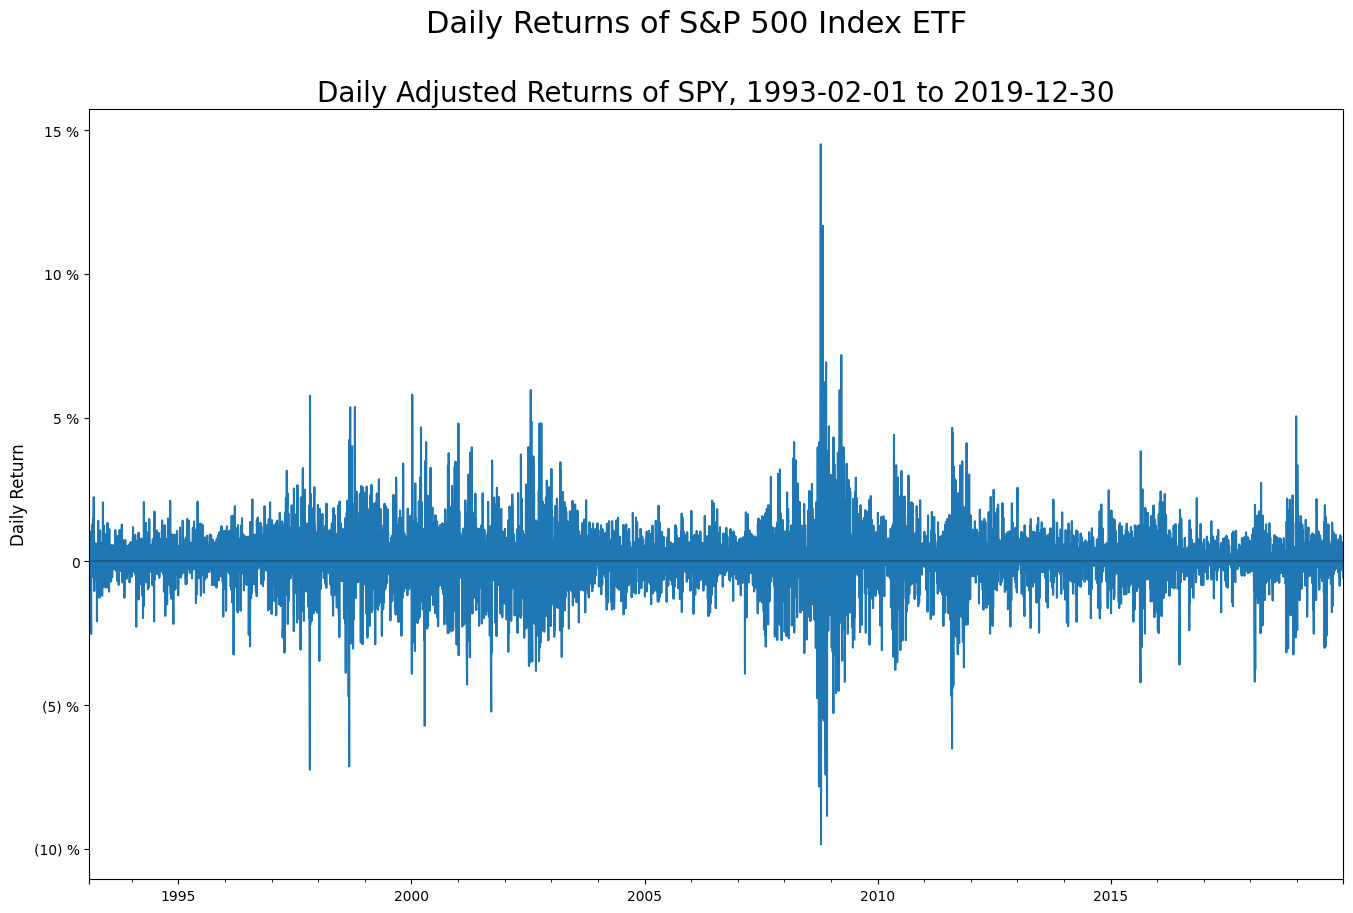

In [40]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
data['Return'].plot(ax=plot)
plot.set_ylabel("Daily Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(0))
figure.suptitle(title:="Daily Returns of {}".format(ticker_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
plot.axhline(color='black',alpha=0.2)
nprint("Wrote plot to {}.".format(filename))

## Analyse Returns by Selected Period
### First Just a Simple Grouped Mean

13:57:21 t Test for a Zero Mean


S&P 500 Index ETF,Mean,Std.Dev.,Count,Std.Err.,t Statistic,p Value,Significance
Month,,,,,,,
January,0.038048,1.121076,531,0.048651,0.782076,0.434519,
February,0.015455,1.022405,518,0.044922,0.344043,0.730954,
March,0.071040,1.149217,591,0.047272,1.502786,0.133429,
April,0.094163,1.033271,557,0.043781,2.150771,0.031925,*
May,0.033056,0.969627,572,0.040542,0.815359,0.415207,
June,0.010261,0.950363,577,0.039564,0.259339,0.795466,
July,0.043392,1.011233,570,0.042356,1.024470,0.306049,
August,-0.012832,1.161860,599,0.047472,-0.270301,0.787022,
September,0.003635,1.208788,547,0.051684,0.070327,0.943959,


13:57:21 Wrote plot to Average Returns of S&P 500 Index ETF by Month.png.


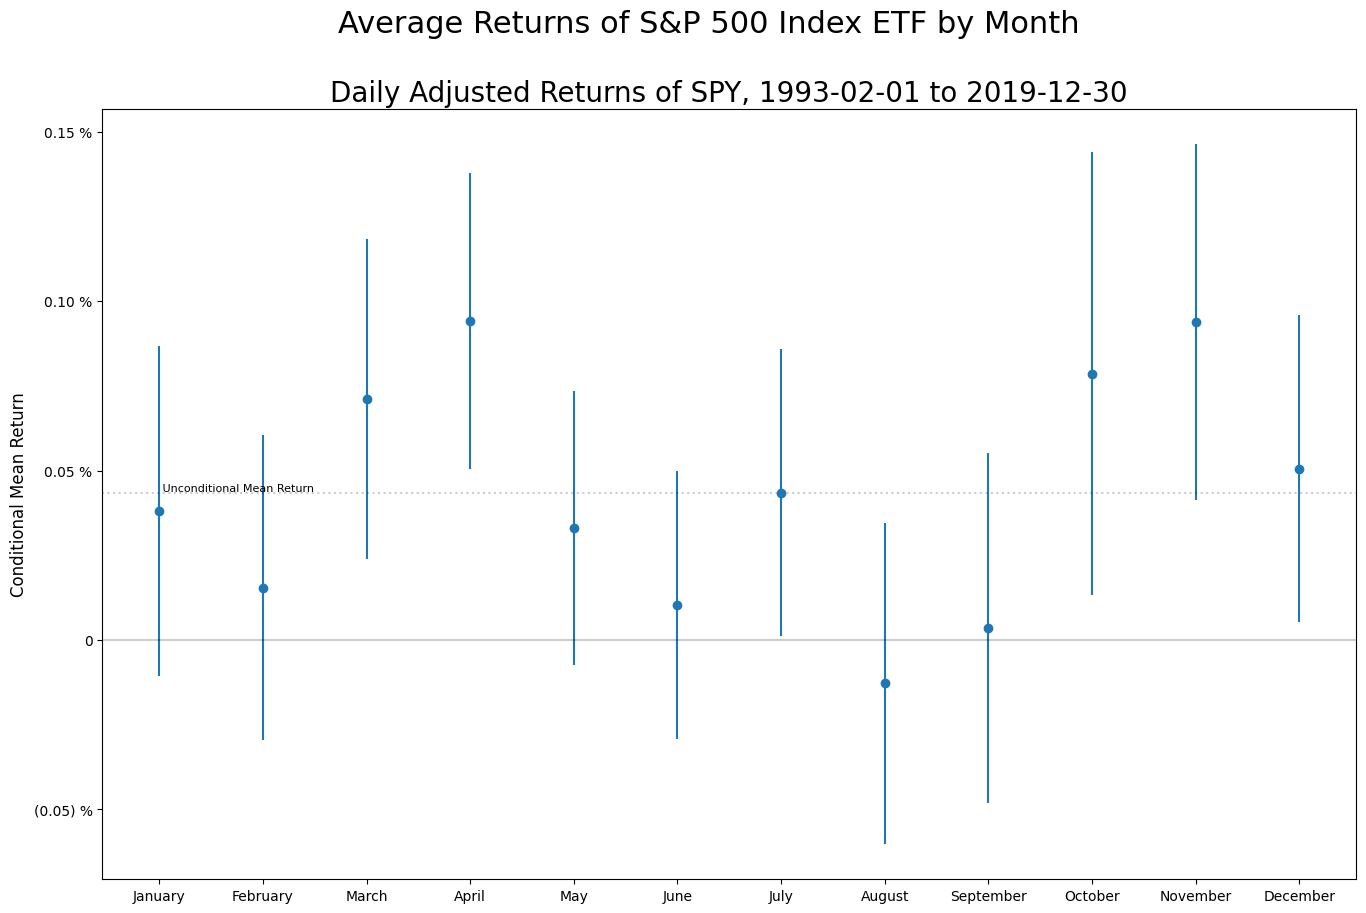

In [48]:
from scipy.stats import t as studentt

nprint("t Test for a Zero Mean")
results=(grouped:=data[['Return',group_name:='Month']].groupby(group_name)).mean().rename(columns={'Return':'Mean'})
results['Std.Dev.']=grouped.std()
results['Count']=grouped.count()
results['Std.Err.']=results['Std.Dev.']/np.sqrt(results['Count'])
results['t Statistic']=results['Mean']/results['Std.Err.']
results['p Value']=studentt.sf(np.abs(results['t Statistic']),results['Count']-1)*2
results['Significance']=results['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
results.index.name=(group_long_name:='Day of Week' if group_name=='Weekday' else 'Day of Month' if group_name=='Monthday' else group_name)

if group_name=='Weekday':
    results=results.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday'])

elif group_name=='Month':
    results=results.reindex(['January','February','March','April','May','June','July','August','September','October','November','December'])

display(results)

figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=results.index,y:=results['Mean'],ye:=results['Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Conditional Mean Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.set_xlabel(group_long_name if group_name=='Monthday' else None,fontsize=12)
plot.axhline(m:=data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
plot.text(x[0],m,' Unconditional Mean Return',fontsize=8,ha='left',va='bottom')
figure.suptitle(title:="Average Returns of {} by {}".format(ticker_name,group_long_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

### One Way ANOVA Analysis

In [42]:
from statsmodels.formula.api import ols as OLSformula
from statsmodels.stats.anova import anova_lm

nprint("One Way ANOVA Analysis by {}".format(group_name))
anova=anova_lm(OLSformula("Return ~ {}".format(group_name),data).fit(),typ=2).rename(columns={'sum_sq':'Sum of Squares','df':'d.o.f.','PR(>F)':'p Value','F':'F Statistic'})
anova['Significance']=anova['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
anova.index=['Between Groups','Within Groups']
anova.index.name='Variation'
display(anova.replace(np.nan,""))

13:53:59 One Way ANOVA Analysis by Weekday


,Sum of Squares,d.o.f.,F Statistic,p Value,Significance
Variation,,,,,
Between Groups,2.028807,4.0,0.388613,0.816945,
Within Groups,8839.841587,6773.0,,,


### Now do an OLS with Indicator Variables
This will deliver *exactly* the same results as the grouped means, but with some other statistics for "free."

In [43]:
from statsmodels.regression.linear_model import OLS

nprint("Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.")
display(design:=pd.get_dummies(data[group_name],columns=[group_name],dtype=float)[results.index].merge(data['Return'],left_index=True,right_index=True))
fit=ols_fit=OLS(design['Return'],design.drop('Return',axis=1)).fit()
nprint(fit.summary())

13:53:59 Baseline OLS regression with indicator variables. This should produce *exactly* the same results as the conditional means above.


,Monday,Tuesday,Wednesday,Thursday,Friday,Return
1993-02-01,1.0,0.0,0.0,0.0,0.0,0.711334
1993-02-02,0.0,1.0,0.0,0.0,0.0,0.211845
1993-02-03,0.0,0.0,1.0,0.0,0.0,1.057055
1993-02-04,0.0,0.0,0.0,1.0,0.0,0.418364
1993-02-05,0.0,0.0,0.0,0.0,1.0,-0.069413
...,...,...,...,...,...,...
2019-12-23,1.0,0.0,0.0,0.0,0.0,0.152788
2019-12-24,0.0,1.0,0.0,0.0,0.0,0.003111
2019-12-26,0.0,0.0,0.0,1.0,0.0,0.532302
2019-12-27,0.0,0.0,0.0,0.0,1.0,-0.024759


13:53:59                             OLS Regression Results                            
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3886
Date:                Tue, 18 Nov 2025   Prob (F-statistic):              0.817
Time:                        13:53:59   Log-Likelihood:                -10518.
No. Observations:                6778   AIC:                         2.105e+04
Df Residuals:                    6773   BIC:                         2.108e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Monday         0.0401      0.032      1.256

### Now fit a GJR-GARCH(1,1,1) Model with the Same Dummies and Non-Normal Innovations
This is a _way more accurate_ distributional model that the Normal model assumed by OLS. It will weight high-volatility days appropriately.

In [44]:
from scipy.stats import norm

nprint("Fitting GJR-GARCH(1,1,1) Model with GED Innovations")
model=ARX(design["Return"],design.drop('Return',axis=1),constant=False,lags=0)
model.volatility=GARCH2(1,1,1)
model.distribution=GeneralizedError2()
fit=gjr_fit=model.fit(update_freq=0)
nprint(gjr_fit.summary())
data['Volatility']=gjr_fit.conditional_volatility

results=pd.DataFrame({'Estimate':fit.params,'Std.Err.':fit.std_err,'Null Value':[zero]*(len(fit.params)-5)+[np.nan,zero,zero,zero]+[two]})
results['t Score']=(results['Estimate']-results['Null Value'])/results['Std.Err.']
results['p Value']=list(map(lambda x:min(norm.cdf(x),norm.sf(x))*two,results['t Score']))
results['Significance']=results['p Value'].apply(lambda x:'***' if x<=0.001 else '**' if x<=0.01 else '*' if x<0.05 else '')
display(results.replace(np.nan,""))

13:53:59 Fitting GJR-GARCH(1,1,1) Model with GED Innovations
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8763.60243431051
            Iterations: 18
            Function evaluations: 232
            Gradient evaluations: 18
13:54:00                               AR-X - GJR-GARCH Model Results                              
Dep. Variable:                             Return   R-squared:                      -0.000
Mean Model:                                  AR-X   Adj. R-squared:                 -0.001
Vol Model:                              GJR-GARCH   Log-Likelihood:               -8763.60
Distribution:      Generalized Error Distribution   AIC:                           17547.2
Method:                        Maximum Likelihood   BIC:                           17615.4
                                                    No. Observations:                 6778
Date:                            Tue, Nov 18 2025   Df Residuals:                   

,Estimate,Std.Err.,Null Value,t Score,p Value,Significance
Monday,0.053275,0.019000,0.0,2.80391,0.005049,**
Tuesday,0.035981,0.021176,0.0,1.699167,0.089288,
Wednesday,0.075192,0.018084,0.0,4.157907,0.000032,***
Thursday,0.042087,0.019450,0.0,2.16386,0.030475,*
Friday,0.071242,0.020476,0.0,3.479318,0.000503,***
omega,0.017798,0.003186,,,,
alpha[1],-0.001304,0.006676,0.0,-0.195314,0.845147,
gamma[1],0.196254,0.023180,0.0,8.466481,0.0,***
beta[1],0.886567,0.012111,0.0,73.202229,0.0,***
nu,1.354814,0.037184,2.0,-17.351114,0.0,***


### Repeat the Simple Plot by Selected Period

13:54:00 Wrote plot to Estimated Daily Returns of S&P 500 Index ETF by Day of Week.png.


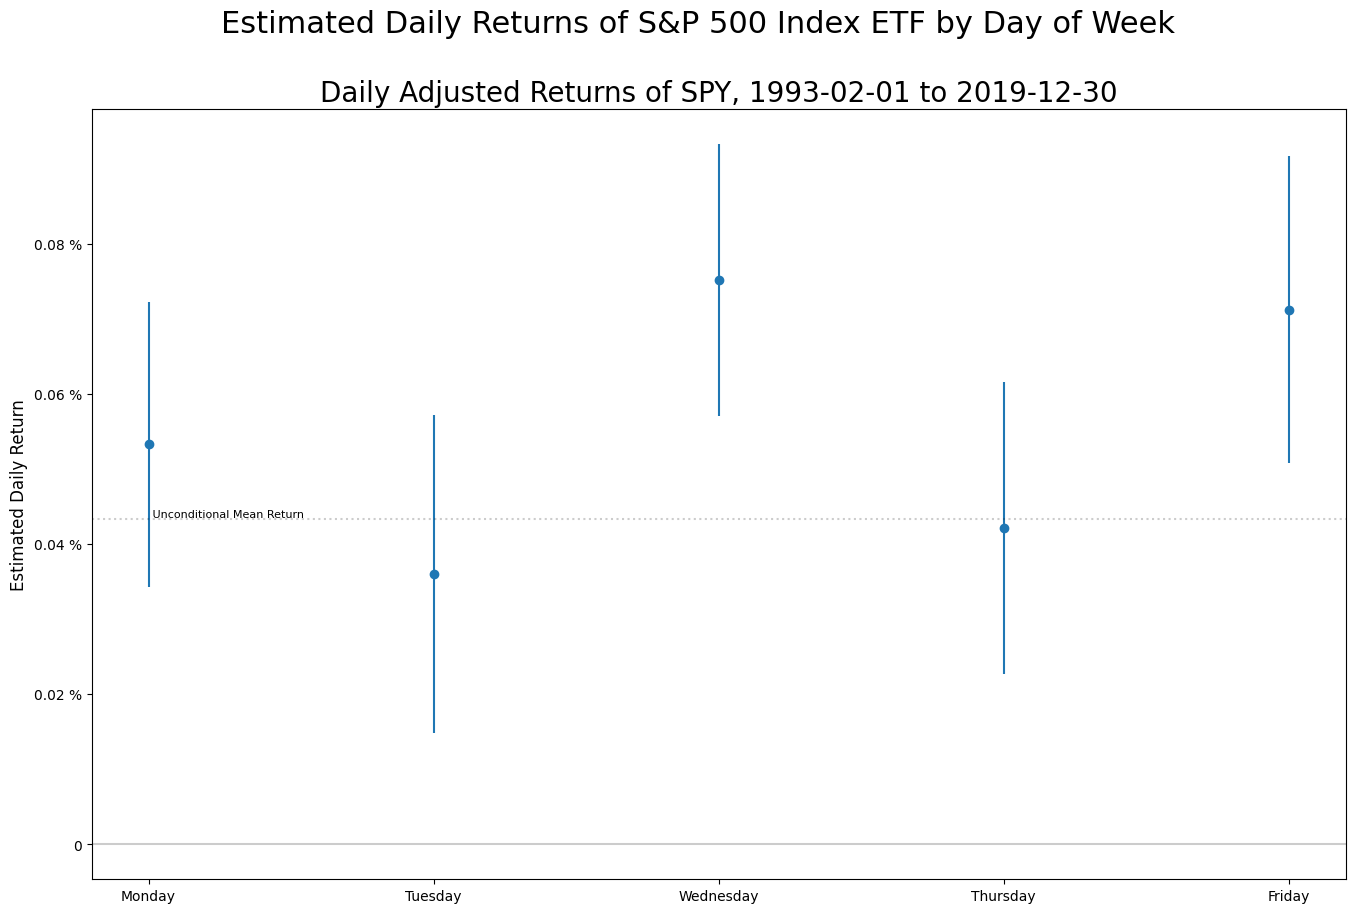

In [45]:
figure,plot=pl.subplots(figsize=(ten*GoldenRatio,ten))
plot.errorbar(x:=results.index[:-5],results.loc[x,'Estimate'],results.loc[x,'Std.Err.'],fmt='o')
plot.axhline(color='black',alpha=0.2)
plot.set_ylabel("Estimated Daily Return",fontsize=12)
plot.yaxis.set_major_formatter(PercentLabels(2))
plot.axhline(m:=data['Return'].mean(),color='black',alpha=0.2,linestyle=':')
plot.text(x[0],m,' Unconditional Mean Return',fontsize=8,ha='left',va='bottom')
figure.suptitle(title:="Estimated Daily Returns of {} by {}".format(ticker_name,group_long_name),fontsize=22)
plot.set_title(subtitle:="Daily Adjusted Returns of {}, {} to {}".format(ticker,data.index[0],data.index[-1]),fontsize=20)
figure.savefig(filename:=title+'.png',dpi=300,bbox_inches='tight')
nprint("Wrote plot to {}.".format(filename))

### Compute the MLRT and AIC changes

In [46]:
from scipy.stats import chi2

aic=pd.DataFrame({
    'Model':['OLS','GJR-GARCH(1,1,1)'],
    'AIC':[ols_fit.aic,gjr_fit.aic],
    '-logL':[ols_fit.llf,gjr_fit.loglikelihood],
    'params':[ols_fit.params.shape[0]+1,gjr_fit.params.shape[0]]
}).set_index('Model')
aic.loc['Change']=aic.diff().iloc[-1]
aic.loc['Change','Chi.Sq.']=aic.loc['Change','-logL']*two
aic.loc['Change','p Value']=chi2.sf(aic.loc['Change','Chi.Sq.'],aic.loc['Change','params'])
display(aic.replace(np.nan,""))

,AIC,-logL,params,Chi.Sq.,p Value
Model,,,,,
OLS,21045.278651,-10517.639325,6.0,,
"GJR-GARCH(1,1,1)",17547.204869,-8763.602434,10.0,,
Change,-3498.073782,1754.036891,4.0,3508.073782,0.0
